In [55]:
from sympy import symbols, init_printing
init_printing()
from celmech.hamiltonian import AndoyerHamiltonian
from celmech.transformations import poincare_vars_to_andoyer_vars, poincare_vars_from_sim
from celmech.transformations import jacobi_masses_from_sim, get_scaled_andoyer_params

In [66]:
import rebound
import numpy as np

def make_sim(j, k):
    mass = 1.e-5
    e0 = 0.01 # initial eccentricity of planets
    
    sim = rebound.Simulation()
    sim.G = 4*np.pi**2
    sim.add(m=1.)
    sim.add(m=mass, e=e0, pomega = np.pi/2., P=1., theta=np.pi)
    sim.add(m=4*mass, e=1.e-5, P=j/float(j-k))
    sim.move_to_com()
    return sim

j=5
k=1
sim = make_sim(j,k)

In [67]:
from celmech.disturbing_function import laplace_coefficient
mjac, Mjac, mu = jacobi_masses_from_sim(sim)
pvars = poincare_vars_from_sim(sim)

In [68]:
'''
ps = sim.particles
s=0 
alpha = ps[1].a/ps[2].a
deltan = ps[1].n-ps[2].n
LambdaOut = pvars[4]
prefac = mu[2]/LambdaOut**2*mjac[1]/Mjac[1]/deltan
for j in range(1,150):
    s += laplace_coefficient(0.5, j, 0, alpha)*np.cos(j*(ps[1].l - ps[2].l))
s -= alpha*np.cos(ps[1].l - ps[2].l)
s *= prefac
pvars[0] -= s # update numerical value of Lambda
pvars[4] += s
'''

'\nps = sim.particles\ns=0 \nalpha = ps[1].a/ps[2].a\ndeltan = ps[1].n-ps[2].n\nLambdaOut = pvars[4]\nprefac = mu[2]/LambdaOut**2*mjac[1]/Mjac[1]/deltan\nfor j in range(1,150):\n    s += laplace_coefficient(0.5, j, 0, alpha)*np.cos(j*(ps[1].l - ps[2].l))\ns -= alpha*np.cos(ps[1].l - ps[2].l)\ns *= prefac\npvars[0] -= s # update numerical value of Lambda\npvars[4] += s\n'

In [69]:
Lambda10 = pvars[0]
n10 = ps[1].n
n20 = ps[2].n
ps = sim.particles
x = poincare_vars_to_andoyer_vars(pvars, sim.G, ps[0].m, mjac[1], mjac[2], n10, n20, j, k, actionScale=Lambda10)
Phi0, phi0, W0, w0, Brouwer0, K0, Acoeff, Bcoeff, Ccoeff = x
pscale, tscale, Phiprime = get_scaled_andoyer_params(Acoeff, Bcoeff, Ccoeff, k)

In [70]:
W0, Brouwer0, K0

In [71]:
pscale, tscale, Phiprime

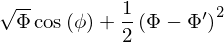

In [72]:
Hsim = AndoyerHamiltonian(k, Phiprime, Phi0/pscale, phi0)
Hsim.H

In [73]:
Norbits = 300
Nout = 1000
tmax = Norbits*sim.particles[1].P
times = np.linspace(0, tmax, Nout)
symtimes = times/abs(tscale)

Nsol = np.zeros((2, Nout))
symsol = np.zeros((2, Nout))
pratio, BrouwerErr, WErr, KErr = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    pratio[i] = ps[2].P/ps[1].P
    Hsim.integrate(symtimes[i])
    symsol[:,i] = Hsim.integrator.y
    pvars = poincare_vars_from_sim(sim)
    x = poincare_vars_to_andoyer_vars(pvars, sim.G, ps[0].m, mjac[1], mjac[2], n10, n20, j, k, actionScale=Lambda10)
    Phi0, phi0, W, w, Brouwer, K, Acoeff, Bcoeff, Ccoeff = x
    BrouwerErr[i] = abs((Brouwer-Brouwer0)/Brouwer0)
    WErr[i] = abs((W-W0)/W0)
    #KErr[i] = abs((K-K0)/K0)
    Nsol[:,i] = [Phi0/pscale, phi0]

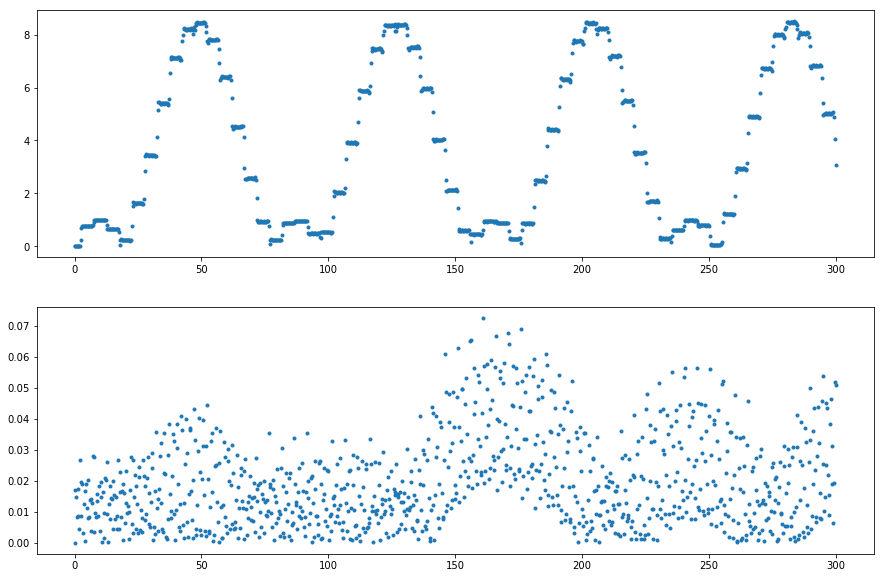

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axarr = plt.subplots(figsize=(15,10), nrows=2)
axarr[0].plot(times, BrouwerErr, '.')
axarr[1].plot(times, WErr, '.')

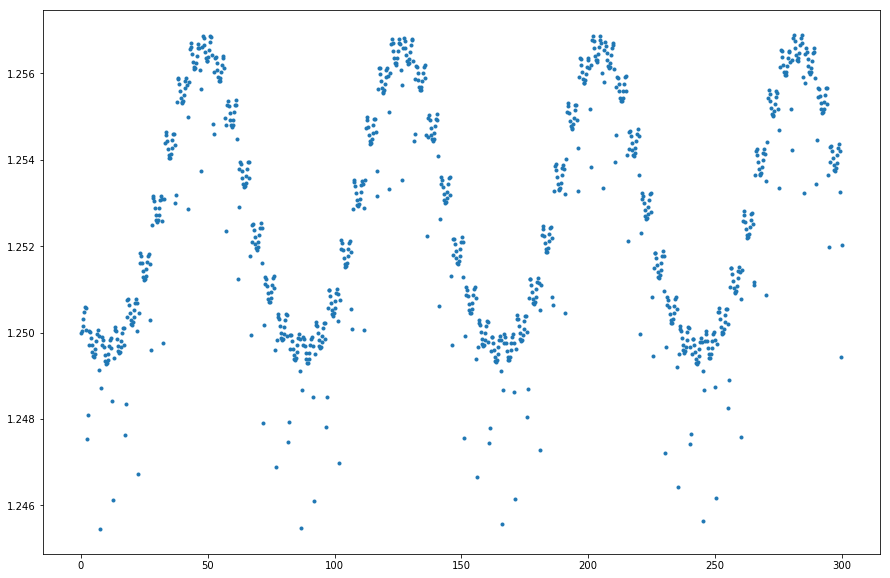

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.plot(times, pratio, '.')

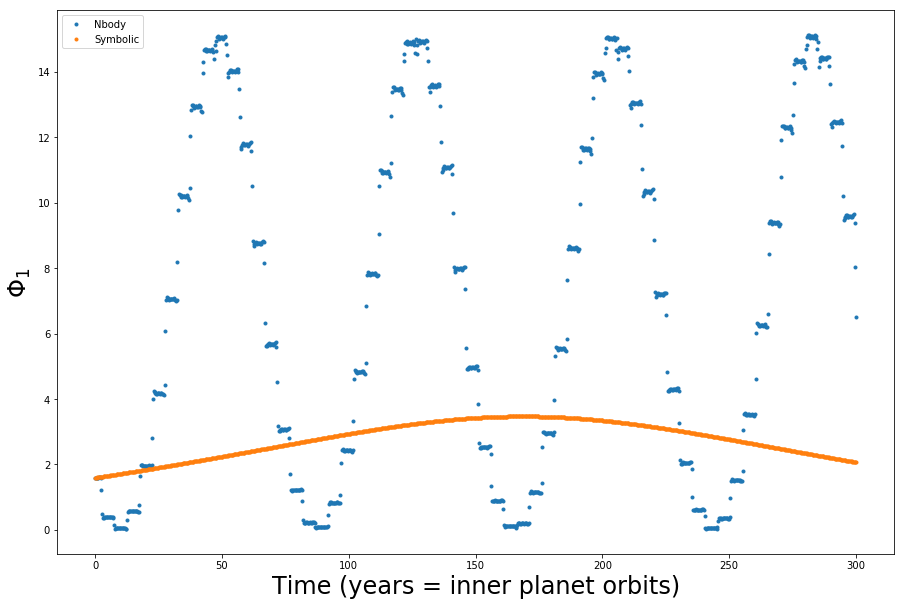

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
ax.set_xlabel("Time (years = inner planet orbits)", fontsize=24)
ax.set_ylabel(r"$\Phi_1$", fontsize=24)

ax.plot(times, Nsol[0,:], '.', label='Nbody')
ax.plot(times, symsol[0,:], '.', label='Symbolic')

ax.legend()

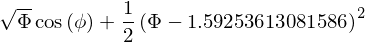

In [9]:
Hsim.NH

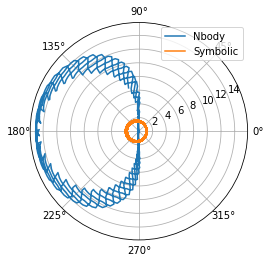

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt

ax = plt.subplot('111', projection='polar')
ax.plot(Nsol[1,:], Nsol[0,:], label='Nbody')
ax.plot(symsol[1,:], symsol[0,:], label='Symbolic')
ax.legend()